<a href="https://colab.research.google.com/github/sabertooth9/chameleon-clustering/blob/main/Chameleon-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*METIS INSTALLATION*

In [ ]:
!pip install metis
!wget http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/OLD/metis-5.0.3.tar.gz
!tar -xf metis-5.0.3.tar.gz
!mv metis-5.0.3/* ../content/
!make config shared=1
!make install
%env METIS_DLL=/usr/local/lib/libmetis.so

  Created wheel for metis: filename=metis-0.2a5-cp36-none-any.whl size=11321 sha256=04a516c6560cf622bc43dac4a7a761a2332b69b9084b116d089a994629d88657
  Stored in directory: /root/.cache/pip/wheels/75/e7/ad/e1fc9b2eb3324d0c9e98335b35c252d22556ab6c78642aa414
Successfully built metis
--2021-02-14 16:30:24--  http://glaros.dtc.umn.edu/gkhome/fetch/sw/metis/OLD/metis-5.0.3.tar.gz
Resolving glaros.dtc.umn.edu (glaros.dtc.umn.edu)... 160.94.40.33
Connecting to glaros.dtc.umn.edu (glaros.dtc.umn.edu)|160.94.40.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4979585 (4.7M) [application/x-gzip]
Saving to: ‘metis-5.0.3.tar.gz’

metis-5.0.3.tar.gz  100%[===================>]   4.75M  3.65MB/s    in 1.3s    

2021-02-14 16:30:26 (3.65 MB/s) - ‘metis-5.0.3.tar.gz’ saved [4979585/4979585]

rm -rf build/Linux-x86_64
mkdir -p build/Linux-x86_64
cd build/Linux-x86_64 && cmake /content -DCMAKE_VERBOSE_MAKEFILE=1 -DGKLIB_PATH=/content/GKlib -DSHARED=1
-- The C compiler identific

In [ ]:
import metis
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.cluster import KMeans, MeanShift, DBSCAN, Birch
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
import networkx as nx
import itertools
from scipy.special import comb
from tqdm import tqdm

In [ ]:
class Chameleon():
    def __init__(self):
        self.cmap = plt.get_cmap('viridis')
        self.colors = [self.cmap(i) for i in np.linspace(0, 1, 10)]

    def plot2d_graph(self, graph):
        pos = nx.get_node_attributes(graph, 'pos')
        c = [self.colors[i % (len(self.colors))]
             for i in nx.get_node_attributes(graph, 'cluster').values()]
        if c:  # is set
            nx.draw(graph, pos, node_color=c, node_size=0.25)
        else:
            nx.draw(graph, pos, node_size=0.25)
        plt.show(block=False)

    def plot2d_data(self, df):
        if (len(df.columns) > 3):
            print("Plot Waring: more than 2-Dimensions!")
        df.plot(kind='scatter', c=df['cluster'], cmap='gist_rainbow', x=0, y=1)
        plt.show(block=False)

    
    def euclidean_distance(self, a, b):
        return np.linalg.norm(np.array(a) - np.array(b))



    def knn_graph(self, df, k, verbose=False):
        points = [p[1:] for p in df.itertuples()]
        g = nx.Graph()
        for i in range(0, len(points)):
            g.add_node(i)
        if verbose:
            print("Building kNN graph (k = %d)..." % (k))
        iterpoints = tqdm(enumerate(points), total=len(
            points)) if verbose else enumerate(points)
        for i, p in iterpoints:
            distances = list(
                map(lambda x: self.euclidean_distance(p, x), points))
            # second trough kth closest
            closests = np.argsort(distances)[1:k+1]
            # print(distances[0])
            for c in closests:
                similar = 1.0/distances[c]*1e4
                similar = max(min(similar, 1e9), -1e9)
                g.add_edge(i, c, weight=1.0 / distances[c], similarity=int(similar))
            g.nodes[i]['pos'] = p
        g.graph['edge_weight_attr'] = 'similarity'
        return g

    def part_graph(self, graph, k, df=None):
        edgecuts, parts = metis.part_graph(
            graph, 2 , objtype='cut')
        # print(edgecuts)
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = parts[i]
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def pre_part_graph(self, graph, k, df=None, verbose=False):
        if verbose:
            print("Begin clustering...")
        clusters = 0
        for i, p in enumerate(graph.nodes()):
            graph.nodes[p]['cluster'] = 0
        cnts = {}
        cnts[0] = len(graph.nodes())
        while clusters < k - 1:
            maxc = -1
            maxcnt = 0
            for key, val in cnts.items():
                if val > maxcnt:
                    maxcnt = val
                    maxc = key
            s_nodes = [n for n in graph.nodes if graph.nodes[n]
                       ['cluster'] == maxc]
            s_graph = graph.subgraph(s_nodes)
            edgecuts, parts = metis.part_graph(
                s_graph, 2 , objtype='cut')
            new_part_cnt = 0
            for i, p in enumerate(s_graph.nodes()):
                if parts[i] == 1:
                    graph.nodes[p]['cluster'] = clusters + 1
                    new_part_cnt = new_part_cnt + 1
            cnts[maxc] = cnts[maxc] - new_part_cnt
            cnts[clusters + 1] = new_part_cnt
            clusters = clusters + 1
        
        edgecuts, parts = metis.part_graph(graph, k)
        if df is not None:
            df['cluster'] = nx.get_node_attributes(graph, 'cluster').values()
        return graph

    def get_cluster(self, graph, clusters):
        nodes = [n for n in graph.nodes if graph.nodes[n]['cluster'] in clusters]
        return nodes

    def connecting_edges(self, partitions, graph):
        cut_set = []
        for a in partitions[0]:
            for b in partitions[1]:
                if a in graph:
                    if b in graph[a]:
                        cut_set.append((a, b))
        return cut_set

    def min_cut_bisector(self, graph):
        graph = graph.copy()
        graph = self.part_graph(graph, 2)
        partitions = self.get_cluster(graph, [0]), self.get_cluster(graph, [1])
        return self.connecting_edges(partitions, graph)

    def get_weights(self, graph, edges):
        return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

    def bisection_weights(self, graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = self.min_cut_bisector(cluster)
        weights = self.get_weights(cluster, edges)
        return weights


    def external_index(self , v1, v2):
        TP, FN, FP, TN = self.confusion_index(v1, v2)
        RI = (TP + TN) / (TP + FN + FP + TN)
        ARI = 2 * (TP * TN - FN * FP) / ((TP + FN) *
                                        (FN + TN) + (TP + FP) * (FP + TN))
        JI = TP / (TP + FN + FP)
        FM = TP / np.sqrt((TP + FN) * (TP + FP))
        return RI, ARI, JI, FM


    def confusion_index(self , v1, v2):
        cmatrix = self.contingency(v1, v2)
        size = np.size(v1)
        sum_rows = np.sum(cmatrix, 0)
        sum_cols = np.sum(cmatrix, 1)
        N = comb(size, 2)
        TP = np.sum(list(map(lambda x: comb(x, 2), cmatrix)))
        FN = np.sum(list(map(lambda x: comb(x, 2), sum_rows))) - TP
        FP = np.sum(list(map(lambda x: comb(x, 2), sum_cols))) - TP
        TN = N - TP - FN - FP
        return TP, FN, FP, TN


    def contingency(self , v1, v2):
        res = np.zeros((np.max(v1), np.max(v2)))
        for i in range(0, np.size(v1)):
            res[v1[i] - 1, v2[i] - 1] = res[v1[i] - 1, v2[i] - 1] + 1
        return res


    def internal_interconnectivity(self , graph, cluster):
        return np.sum(self.bisection_weights(graph, cluster))


    def relative_interconnectivity(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        EC = np.sum(self.get_weights(graph, edges))
        ECci, ECcj = self.internal_interconnectivity(graph, cluster_i), self.internal_interconnectivity(graph, cluster_j)
        return EC / ((ECci + ECcj) / 2.0)


    def internal_closeness(self , graph, cluster):
        cluster = graph.subgraph(cluster)
        edges = cluster.edges()
        weights = self.get_weights(cluster, edges)
        return np.sum(weights)


    def relative_closeness(self , graph, cluster_i, cluster_j):
        edges = self.connecting_edges((cluster_i, cluster_j), graph)
        if not edges:
            return 0.0
        else:
            SEC = np.mean(self.get_weights(graph, edges))
        Ci, Cj = self.internal_closeness(graph, cluster_i), self.internal_closeness(graph, cluster_j)
        SECci, SECcj = np.mean(self.bisection_weights(graph, cluster_i)), np.mean(
            self.bisection_weights(graph, cluster_j))
        return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))


    def merge_score(self , g, ci, cj, a):
        return self.relative_interconnectivity(g, ci, cj) * np.power(self.relative_closeness(g, ci, cj), a)


    def merge_best(self , graph, df, a, k, verbose=False):
        clusters = np.unique(df['cluster'])
        max_score = 0
        ci, cj = -1, -1
        if len(clusters) <= k:
            return False

        for combination in itertools.combinations(clusters, 2):
            i, j = combination
            if i != j:
                if verbose:
                    print("Checking c%d c%d" % (i, j))
                gi = self.get_cluster(graph, [i])
                gj = self.get_cluster(graph, [j])
                edges = self.connecting_edges((gi, gj), graph)
                if not edges:
                    continue
                ms = self.merge_score(graph, gi, gj, a)
                if verbose:
                    print("Merge score: %f" % (ms))
                if ms > max_score:
                    if verbose:
                        print("Better than: %f" % (max_score))
                    max_score = ms
                    ci, cj = i, j

        if max_score > 0:
            if verbose:
                print("Merging c%d and c%d" % (ci, cj))
            df.loc[df['cluster'] == cj, 'cluster'] = ci
            for i, p in enumerate(graph.nodes()):
                if graph.nodes[p]['cluster'] == cj:
                    graph.nodes[p]['cluster'] = ci
                
        return max_score > 0


    def cluster(self , df, k, knn=10, m=30, alpha=2.0, verbose=False , plot=False):
        graph = self.knn_graph(df, knn, verbose=True)
        graph = self.pre_part_graph(graph, m, df, verbose=True)
        iterm = tqdm(enumerate(range(m - k)), total=m-k)
        for i in iterm:
            self.merge_best(graph, df, alpha, k, verbose)
            if plot:
                self.plot2d_data(df)
                
        res = self.rebuild_labels(df)
        return res


    def rebuild_labels(self , df):
        ans = df.copy()
        clusters = list(pd.DataFrame(df['cluster'].value_counts()).index)
        c = 1
        for i in clusters:
            ans.loc[df['cluster'] == i, 'cluster'] = c
            c = c + 1
        return ans


  4%|▎         | 18/506 [00:00<00:02, 174.54it/s]

Building kNN graph (k = 20)...


100%|██████████| 506/506 [00:03<00:00, 153.42it/s]


Begin clustering...


  0%|          | 0/38 [00:00<?, ?it/s]

Plot Waring: more than 2-Dimensions!


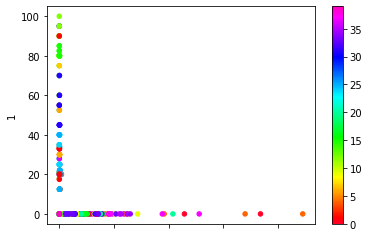

  3%|▎         | 1/38 [00:02<01:38,  2.66s/it]

Plot Waring: more than 2-Dimensions!


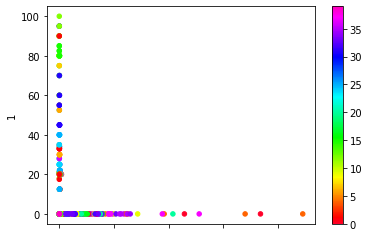

  5%|▌         | 2/38 [00:05<01:34,  2.64s/it]

Plot Waring: more than 2-Dimensions!


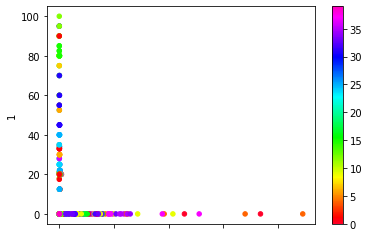

  8%|▊         | 3/38 [00:07<01:31,  2.61s/it]

Plot Waring: more than 2-Dimensions!


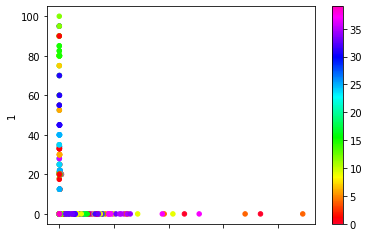

 11%|█         | 4/38 [00:10<01:28,  2.60s/it]

Plot Waring: more than 2-Dimensions!


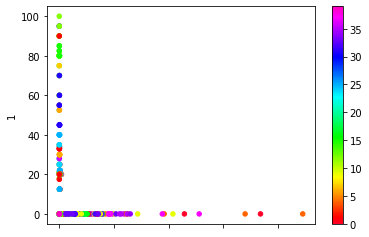

 13%|█▎        | 5/38 [00:12<01:25,  2.59s/it]

Plot Waring: more than 2-Dimensions!


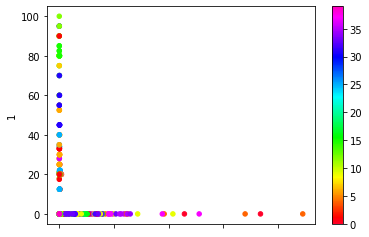

 16%|█▌        | 6/38 [00:15<01:21,  2.56s/it]

Plot Waring: more than 2-Dimensions!


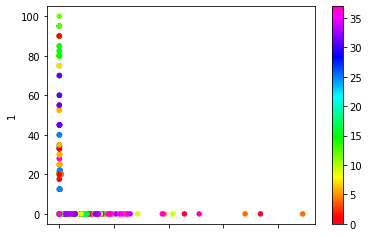

 18%|█▊        | 7/38 [00:18<01:19,  2.58s/it]

Plot Waring: more than 2-Dimensions!


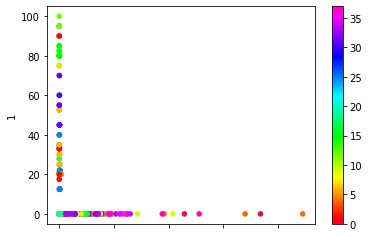

 21%|██        | 8/38 [00:20<01:16,  2.56s/it]

Plot Waring: more than 2-Dimensions!


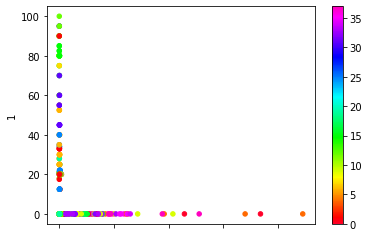

 24%|██▎       | 9/38 [00:22<01:12,  2.51s/it]

Plot Waring: more than 2-Dimensions!


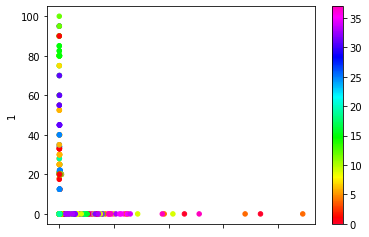

 26%|██▋       | 10/38 [00:25<01:09,  2.47s/it]

Plot Waring: more than 2-Dimensions!


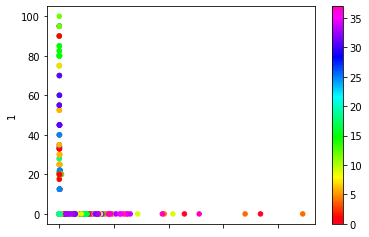

 29%|██▉       | 11/38 [00:27<01:05,  2.44s/it]

Plot Waring: more than 2-Dimensions!


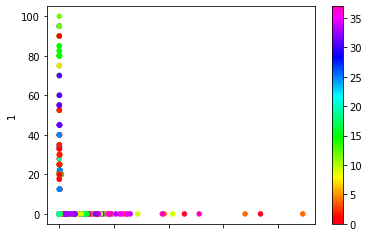

 32%|███▏      | 12/38 [00:30<01:02,  2.42s/it]

Plot Waring: more than 2-Dimensions!


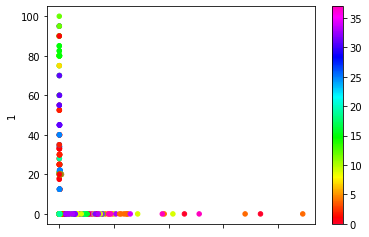

 34%|███▍      | 13/38 [00:32<01:00,  2.43s/it]

Plot Waring: more than 2-Dimensions!


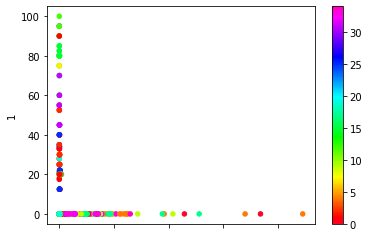

 37%|███▋      | 14/38 [00:35<00:58,  2.46s/it]

Plot Waring: more than 2-Dimensions!


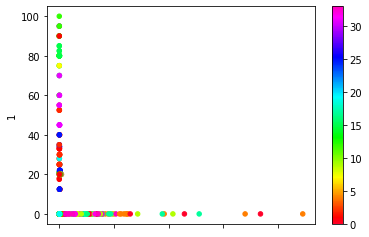

 39%|███▉      | 15/38 [00:37<00:56,  2.44s/it]

Plot Waring: more than 2-Dimensions!


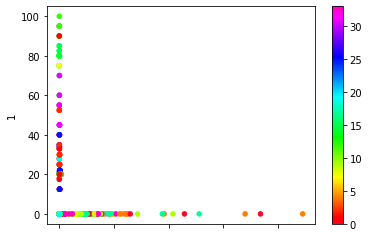

 42%|████▏     | 16/38 [00:39<00:53,  2.42s/it]

Plot Waring: more than 2-Dimensions!


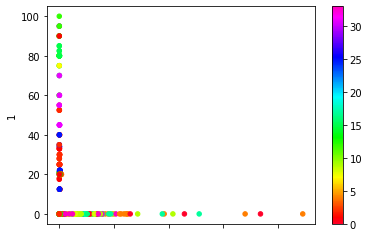

 45%|████▍     | 17/38 [00:42<00:50,  2.39s/it]

Plot Waring: more than 2-Dimensions!


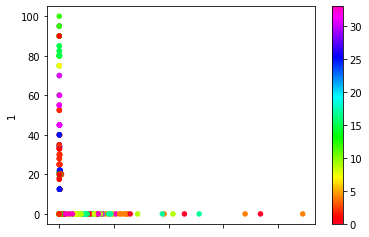

 47%|████▋     | 18/38 [00:44<00:47,  2.39s/it]

Plot Waring: more than 2-Dimensions!


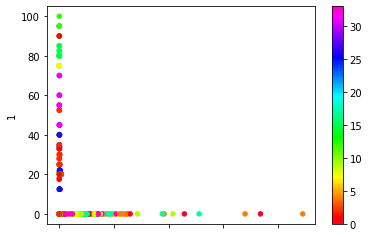

 50%|█████     | 19/38 [00:46<00:44,  2.37s/it]

Plot Waring: more than 2-Dimensions!


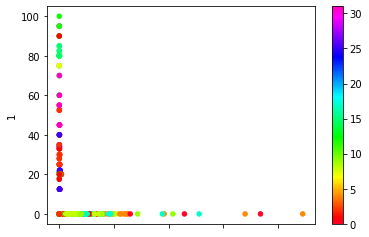

 53%|█████▎    | 20/38 [00:49<00:43,  2.41s/it]

Plot Waring: more than 2-Dimensions!


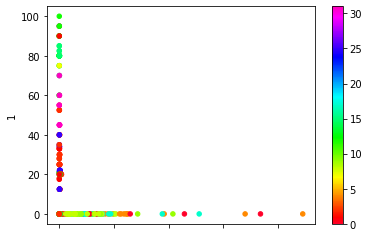

 55%|█████▌    | 21/38 [00:51<00:40,  2.41s/it]

Plot Waring: more than 2-Dimensions!


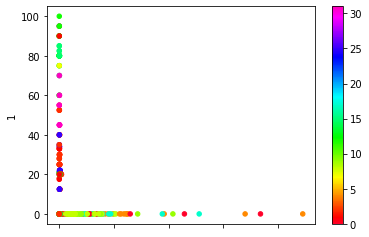

 58%|█████▊    | 22/38 [00:54<00:38,  2.38s/it]

Plot Waring: more than 2-Dimensions!


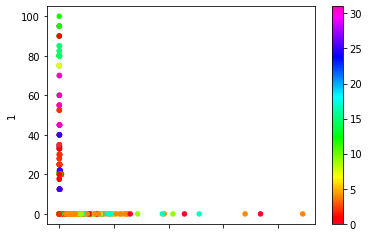

 61%|██████    | 23/38 [00:56<00:35,  2.35s/it]

Plot Waring: more than 2-Dimensions!


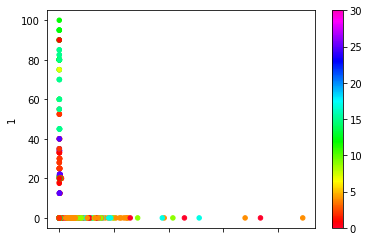

 63%|██████▎   | 24/38 [00:58<00:32,  2.32s/it]

Plot Waring: more than 2-Dimensions!


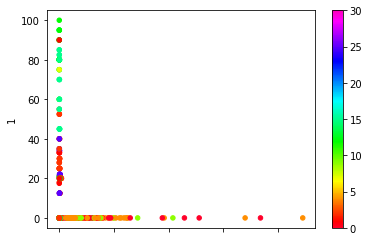

 66%|██████▌   | 25/38 [01:00<00:29,  2.26s/it]

Plot Waring: more than 2-Dimensions!


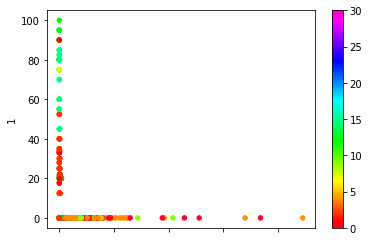

 68%|██████▊   | 26/38 [01:02<00:26,  2.24s/it]

Plot Waring: more than 2-Dimensions!


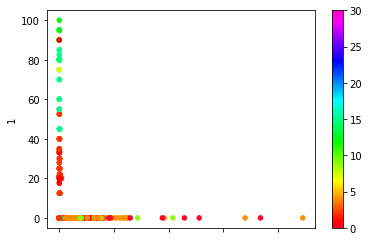

 71%|███████   | 27/38 [01:04<00:23,  2.15s/it]

Plot Waring: more than 2-Dimensions!


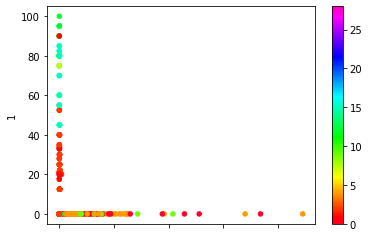

 74%|███████▎  | 28/38 [01:06<00:20,  2.08s/it]

Plot Waring: more than 2-Dimensions!


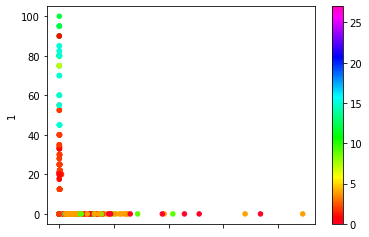

 76%|███████▋  | 29/38 [01:08<00:18,  2.01s/it]

Plot Waring: more than 2-Dimensions!


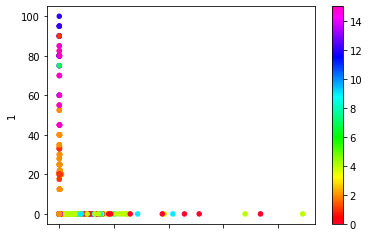

 79%|███████▉  | 30/38 [01:10<00:15,  1.94s/it]

Plot Waring: more than 2-Dimensions!


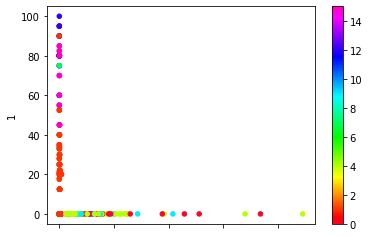

 82%|████████▏ | 31/38 [01:12<00:13,  1.90s/it]

Plot Waring: more than 2-Dimensions!


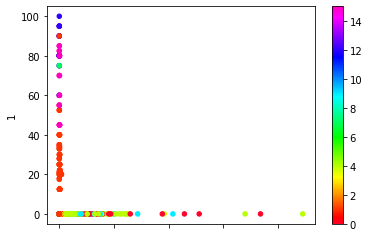

 84%|████████▍ | 32/38 [01:14<00:11,  1.90s/it]

Plot Waring: more than 2-Dimensions!


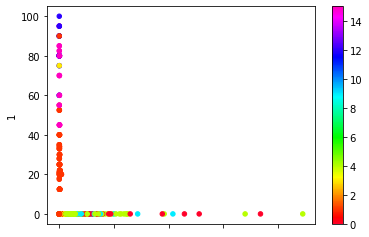

 87%|████████▋ | 33/38 [01:15<00:09,  1.81s/it]

Plot Waring: more than 2-Dimensions!


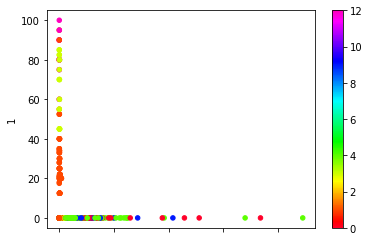

 89%|████████▉ | 34/38 [01:17<00:06,  1.69s/it]

Plot Waring: more than 2-Dimensions!


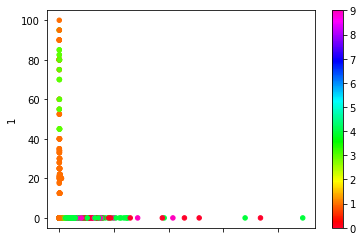

 92%|█████████▏| 35/38 [01:18<00:04,  1.55s/it]

Plot Waring: more than 2-Dimensions!


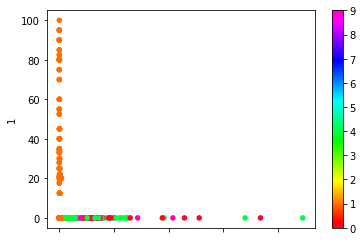

 95%|█████████▍| 36/38 [01:19<00:02,  1.38s/it]

Plot Waring: more than 2-Dimensions!


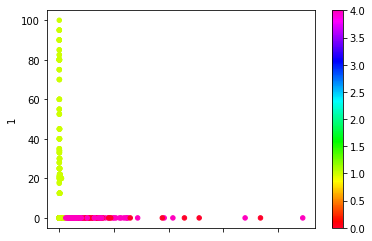

 97%|█████████▋| 37/38 [01:19<00:01,  1.16s/it]

Plot Waring: more than 2-Dimensions!


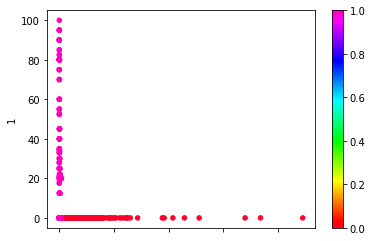

100%|██████████| 38/38 [01:20<00:00,  2.12s/it]


Plot Waring: more than 2-Dimensions!


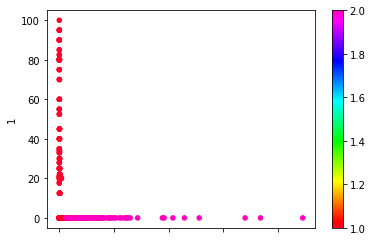

In [ ]:
# get a set of data points
data = datasets.load_boston()
X, y = pd.DataFrame(data.data), data.target

chameleon_cluster = Chameleon()

# returns a pands.dataframe of cluster
res = chameleon_cluster.cluster(X, 2, knn=20, m=40, alpha=2.0, plot=True)
# draw a 2-D scatter plot with cluster
chameleon_cluster.plot2d_data(res)